## Set Up Storage Environment

In [ ]:
!pip install geopandas
!pip install shapely
!pip install geopy


In [ ]:
# importing libraries
import pyspark.sql.functions as F
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from pyspark.sql.functions import struct
from geopy.distance import geodesic
from pyspark.sql import Window
import seaborn as sns 
import matplotlib.pyplot as plt

In [ ]:
# specify necessary names for Azure Storage
blob_container = "container1" # The name of your container created in https://portal.azure.com
storage_account = "w261sec6group3" # The name of your Storage account created in https://portal.azure.com
secret_scope = "w261sec6group3_scope" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "w261sec6group3_key" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

# configure blob storage
spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

In [ ]:
# Inspect the Mount's Final Project folder 
display(dbutils.fs.ls("/mnt/mids-w261/datasets_final_project_2022"))

path name size modificationTime dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data/ parquet_airlines_data/ 0 1656618287000 dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data_1y/ parquet_airlines_data_1y/ 0 1656630272000 dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data_3m/ parquet_airlines_data_3m/ 0 1656630114000 dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data_6m/ parquet_airlines_data_6m/ 0 1656630205000 dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data/ parquet_weather_data/ 0 1656622074000 dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data_1y/ parquet_weather_data_1y/ 0 1656631614000 dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data_3m/ parquet_weather_data_3m/ 0 1656630651000 dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data_6m/ parquet_weather_data_6m/ 0 1656631047000 dbfs:/mnt/mids-w261/datasets_final_project_2022/stations_data/ stations_data/ 0 1656713663000

In [ ]:
# Load 3 months of the airline data for EDA
df_airlines_3m = spark.read.parquet("dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data_3m/")
df_airlines_1y = spark.read.parquet("dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data_1y/")
df_airlines = spark.read.parquet("dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data/")
# Load 3 months of the weather data for EDA
df_weather_3m = spark.read.parquet("dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data_3m/")

# Load airport data for EDA
df_station = spark.read.parquet("dbfs:/mnt/mids-w261/datasets_final_project_2022/stations_data/stations_with_neighbors.parquet/")

## EDA and Preprocessing

In [ ]:
def count_missings(spark_df,sort=True):
    """
    Counts number of nulls and nans in each column
    and calculates the precentage nulls.
    """
    df = spark_df.select([(F.count(F.when(F.isnan(c) | F.isnull(c), c))/F.count(F.lit(1))).alias(c) for c in spark_df.columns]).toPandas()
                          #(c,c_type) in spark_df.dtypes if c_type not in ('timestamp', 'date')]).toPandas()

    if len(df) == 0:
        print("There are no missing values!")
        return None

    if sort:
        return df.rename(index={0: 'count'}).T.sort_values("count",ascending=False)

    return df

### EDA: Flight Data

In [ ]:
# see the first 1000 rows of the 3 month flight data
df_airlines_3m.display()

QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_FIPS ORIGIN_STATE_NM ORIGIN_WAC DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK TAXI_OUT WHEELS_OFF WHEELS_ON TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED CANCELLATION_CODE DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME AIR_TIME FLIGHTS DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY FIRST_DEP_TIME TOTAL_ADD_GTIME LONGEST_ADD_GTIME DIV_AIRPORT_LANDINGS DIV_REACHED_DEST DIV_ACTUAL_ELAPSED_TIME DIV_ARR_DELAY DIV_DISTANCE DIV1_AIRPORT DIV1_AIRPORT_ID DIV1_AIRPORT_SEQ_ID DIV1_WHEELS_ON DIV1_TOTAL_GTIME DIV1_LONGEST_GTIME DIV1_WHEELS_OFF DIV1_TAIL_NUM DIV2_AIRPORT DIV2_AIRPORT_ID DIV2_AIRPORT_SEQ_ID DIV2_WHEELS_ON DIV2_TOTAL_GTIME DIV2_LONGEST_GTIME DIV2_WHEELS_OFF DIV2_TAIL_NUM DIV3_AIRPORT DIV3_AIRPORT_ID DIV3_AIRPORT_SEQ_ID DIV3_WHEELS_ON DIV3_TOTAL_GTIME DIV3_LONGEST_GTIME DIV3_WHEELS_OFF DIV3_TAIL_NUM DIV4_AIRPORT DIV4_AIRPORT_ID DIV4_AIRPORT_SEQ_ID DIV4_WHEELS_ON DIV4_TOTAL_GTIME DIV4_LONGEST_GTIME DIV4_WHEELS_OFF DIV4_TAIL_NUM DIV5_AIRPORT DIV5_AIRPORT_ID DIV5_AIRPORT_SEQ_ID DIV5_WHEELS_ON DIV5_TOTAL_GTIME DIV5_LONGEST_GTIME DIV5_WHEELS_OFF DIV5_TAIL_NUM YEAR 1 2 19 4 2015-02-19 AA 19805 AA N520AA 323 15016 1501603 31123 STL St. Louis, MO MO 29 Missouri 64 11298 1129803 30194 DFW Dallas/Fort Worth, TX TX 48 Texas 74 901 949 48.0 48.0 1.0 3 0900-0959 23.0 1012 1130 5.0 1058 1135 37.0 37.0 1.0 2 1000-1059 0.0 null 0.0 117.0 106.0 78.0 1.0 550.0 3 0.0 5.0 0.0 0.0 32.0 null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2015 1 2 20 5 2015-02-20 AA 19805 AA N4XUAA 323 15016 1501603 31123 STL St. Louis, MO MO 29 Missouri 64 11298 1129803 30194 DFW Dallas/Fort Worth, TX TX 48 Texas 74 901 855 -6.0 0.0 0.0 -1 0900-0959 11.0 906 1033 26.0 1058 1059 1.0 1.0 0.0 0 1000-1059 0.0 null 0.0 117.0 124.0 87.0 1.0 550.0 3 null null null null null null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2015 1 2 21 6 2015-02-21 AA 19805 AA N486AA 323 15016 1501603 31123 STL St. Louis, MO MO 29 Missouri 64 11298 1129803 30194 DFW Dallas/Fort Worth, TX TX 48 Texas 74 901 1018 77.0 77.0 1.0 5 0900-0959 11.0 1029 1207 5.0 1058 1212 74.0 74.0 1.0 4 1000-1059 0.0 null 0.0 117.0 114.0 98.0 1.0 550.0 3 27.0 0.0 0.0 0.0 47.0 null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2015 1 2 22 7 2015-02-22 AA 19805 AA N456AA 323 15016 1501603 31123 STL St. Louis, MO MO 29 Missouri 64 11298 1129803 30194 DFW Dallas/Fort Worth, TX TX 48 Texas 74 901 853 -8.0 0.0 0.0 -1 0900-0959 9.0 902 1036 14.0 1058 1050 -8.0 0.0 0.0 -1 1000-1059 0.0 null 0.0 117.0 117.0 94.0 1.0 550.0 3 null null null null null null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2015 1 2 23 1 2015-02-23 AA 19805 AA N4XTAA 323 15016 1501603 31123 STL St. Louis, MO MO 29 Missouri 64 11298 1129803 30194 DFW Dallas/Fort Worth, TX TX 48 Texas 74 901 null null null null n

Output can only be rendered in Databricks

In [ ]:
# Count the number of rows in the 3 months Flight data
df_airlines_3m.count()

Out[5]: 2806942

<b>Comment:</b> The 3 months flight dataset has 2,806,942 rows.

In [ ]:
display(df_airlines_3m.summary())

summary QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_FIPS ORIGIN_STATE_NM ORIGIN_WAC DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK TAXI_OUT WHEELS_OFF WHEELS_ON TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED CANCELLATION_CODE DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME AIR_TIME FLIGHTS DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY FIRST_DEP_TIME TOTAL_ADD_GTIME LONGEST_ADD_GTIME DIV_AIRPORT_LANDINGS DIV_REACHED_DEST DIV_ACTUAL_ELAPSED_TIME DIV_ARR_DELAY DIV_DISTANCE DIV1_AIRPORT DIV1_AIRPORT_ID DIV1_AIRPORT_SEQ_ID DIV1_WHEELS_ON DIV1_TOTAL_GTIME DIV1_LONGEST_GTIME DIV1_WHEELS_OFF DIV1_TAIL_NUM DIV2_AIRPORT DIV2_AIRPORT_ID DIV2_AIRPORT_SEQ_ID DIV2_WHEELS_ON DIV2_TOTAL_GTIME DIV2_LONGEST_GTIME DIV2_WHEELS_OFF DIV2_TAIL_NUM DIV3_AIRPORT DIV3_AIRPORT_ID DIV3_AIRPORT_SEQ_ID DIV3_WHEELS_ON DIV3_TOTAL_GTIME DIV3_LONGEST_GTIME DIV3_WHEELS_OFF DIV3_TAIL_NUM DIV4_AIRPORT DIV4_AIRPORT_ID DIV4_AIRPORT_SEQ_ID DIV4_WHEELS_ON DIV4_TOTAL_GTIME DIV4_LONGEST_GTIME DIV4_WHEELS_OFF DIV4_TAIL_NUM DIV5_AIRPORT DIV5_AIRPORT_ID DIV5_AIRPORT_SEQ_ID DIV5_WHEELS_ON DIV5_TOTAL_GTIME DIV5_LONGEST_GTIME DIV5_WHEELS_OFF DIV5_TAIL_NUM YEAR count 2806942 2806942 2806942 2806942 2806942 2806942 2806942 2806942 2790562 2806942 2806942 2806942 2806942 2806942 2806942 2806942 2806942 2806942 2806942 2806942 2806942 2806942 2806942 2806942 2806942 2806942 2806942 2806942 2806942 2722232 2722232 2722232 2722232 2722232 2806942 2720600 2720600 2718206 2718206 2806942 2718206 2713628 2713628 2713628 2713628 2806942 2806942 87002 2806942 2806938 2713628 2713628 2806942 2806942 2806942 573164 573164 573164 573164 573164 17984 17984 17984 2806942 6312 4578 4578 6312 6972 6972 6972 6972 6972 6972 4676 4676 120 120 120 120 120 120 26 26 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2806942 mean 1.0 2.02447075856929 15.543424837420938 3.9354058616102505 null null 19977.26872945718 null null 2243.9367411225453 12670.940794644135 1267096.738076526 31712.192420078507 null null null 26.044411320219655 null 55.49525497854961 12670.920428708538 1267094.7015264297 31712.161084910196 null null null 26.04658521622463 null 55.49300341795448 1327.6009044718417 1337.3152765818636 10.362709717614075 13.025645867067906 0.20413469535293097 0.1051570916806503 null 16.391046092773653 1360.443575681835 1484.9075875779833 7.461946592715931 1504.7578496456285 1490.8430567808327 6.242928654922488 13.408466451554892 0.21121686539201392 -0.07815514875288727 null 0.030995296660921386 null 0.002248710518421827 140.50779176454913 136.73582672348604 112.89413508410144 1.0 807.1014641556541 3.700602292459196 18.28270791605893 3.1509759859307285 13.455558967415957 0.062341668353211296 22.67369548680657 1269.2220862989325 34.50044483985765 33.955071174377224 0.004401230948127891 0.7252851711026616 369.42245522062035 208.21581476627347 84.0614702154626 null 12740.018932874355 1274004.44205393 1436.2320711417096 25.65146299483649 20.55536431440046 1469.735243798118 null null 12180.666666666666 1218069.6166666667 1314.7666666666667 13.083333333333334 11.55 1371.8461538461538 null null 11331.5 1133154.0 988.0 5.0 5.0 null null null null null null null null null null null null null null null null null null 2015.0 stddev 3.968081201801646E-17 0.8328232775017692 8.694612219485368 1.9969445476919374 null null 397.9610646622378 null null 1793.0792013329797 1519.9179657172444 151991.49143764254 1283.5099590639068 null null null 16.72778042784542 null 26.440692665743384 1519.9341119682522 151993.1060916947 1283.5254600109656 null null null 16.727

In [ ]:
# calculate the percentage missing data for each feature
df = count_missings(df_airlines)

In [ ]:
pd.set_option('display.max_rows', None)
df

Out[9]:

count 
 
 
 
 
 DIV4_TOTAL_GTIME 
 1.000000 
 
 
 DIV5_AIRPORT_ID 
 1.000000 
 
 
 DIV4_WHEELS_ON 
 1.000000 
 
 
 DIV4_AIRPORT 
 1.000000 
 
 
 DIV4_LONGEST_GTIME 
 1.000000 
 
 
 DIV4_WHEELS_OFF 
 1.000000 
 
 
 DIV4_TAIL_NUM 
 1.000000 
 
 
 DIV5_AIRPORT 
 1.000000 
 
 
 DIV4_AIRPORT_SEQ_ID 
 1.000000 
 
 
 DIV4_AIRPORT_ID 
 1.000000 
 
 
 DIV5_AIRPORT_SEQ_ID 
 1.000000 
 
 
 DIV5_WHEELS_ON 
 1.000000 
 
 
 DIV5_TOTAL_GTIME 
 1.000000 
 
 
 DIV5_LONGEST_GTIME 
 1.000000 
 
 
 DIV5_WHEELS_OFF 
 1.000000 
 
 
 DIV5_TAIL_NUM 
 1.000000 
 
 
 DIV3_TAIL_NUM 
 1.000000 
 
 
 DIV3_WHEELS_OFF 
 1.000000 
 
 
 DIV3_LONGEST_GTIME 
 1.000000 
 
 
 DIV3_TOTAL_GTIME 
 1.000000 
 
 
 DIV3_WHEELS_ON 
 1.000000 
 
 
 DIV3_AIRPORT_SEQ_ID 
 1.000000 
 
 
 DIV3_AIRPORT_ID 
 1.000000 
 
 
 DIV3_AIRPORT 
 1.000000 
 
 
 DIV2_WHEELS_OFF 
 0.999991 
 
 
 DIV2_TAIL_NUM 
 0.999991 
 
 
 DIV2_AIRPORT 
 0.999979 
 
 
 DIV2_LONGEST_GTIME 
 0.999979 
 
 
 DIV2_TOTAL_GTIME 
 0.999979 
 
 
 DIV2_WHEELS_ON 
 0.999979 
 
 
 DIV2_AIRPORT_ID 
 0.999979 
 
 
 DIV2_AIRPORT_SEQ_ID 
 0.999979 
 
 
 DIV_ACTUAL_ELAPSED_TIME 
 0.997952 
 
 
 DIV_ARR_DELAY 
 0.997952 
 
 
 DIV1_WHEELS_OFF 
 0.997939 
 
 
 DIV1_TAIL_NUM 
 0.997939 
 
 
 DIV_DISTANCE 
 0.997600 
 
 
 DIV_REACHED_DEST 
 0.997599 
 
 
 DIV1_WHEELS_ON 
 0.997488 
 
 
 DIV1_TOTAL_GTIME 
 0.997488 
 
 
 DIV1_AIRPORT 
 0.997488 
 
 
 DIV1_AIRPORT_ID 
 0.997488 
 
 
 DIV1_LONGEST_GTIME 
 0.997488 
 
 
 DIV1_AIRPORT_SEQ_ID 
 0.997488 
 
 
 LONGEST_ADD_GTIME 
 0.993722 
 
 
 TOTAL_ADD_GTIME 
 0.993722 
 
 
 FIRST_DEP_TIME 
 0.993722 
 
 
 CANCELLATION_CODE 
 0.981612 
 
 
 LATE_AIRCRAFT_DELAY 
 0.824199 
 
 
 SECURITY_DELAY 
 0.824199 
 
 
 NAS_DELAY 
 0.824199 
 
 
 WEATHER_DELAY 
 0.824199 
 
 
 CARRIER_DELAY 
 0.824199 
 
 
 ARR_DELAY 
 0.020859 
 
 
 ARR_DELAY_NEW 
 0.020859 
 
 
 ARR_DELAY_GROUP 
 0.020859 
 
 
 ARR_DEL15 
 0.020859 
 
 
 AIR_TIME 
 0.020789 
 
 
 ACTUAL_ELAPSED_TIME 
 0.020789 
 
 
 WHEELS_ON 
 0.018740 
 
 
 TAXI_IN 
 0.018740 
 
 
 ARR_TIME 
 0.018740 
 
 
 TAXI_OUT 
 0.018278 
 
 
 WHEELS_OFF 
 0.018278 
 
 
 DEP_DELAY_GROUP 
 0.018001 
 
 
 DEP_DEL15 
 0.018001 
 
 
 DEP_DELAY_NEW 
 0.018001 
 
 
 DEP_DELAY 
 0.018001 
 
 
 DEP_TIME 
 0.017864 
 
 
 TAIL_NUM 
 0.004251 
 
 
 CRS_ELAPSED_TIME 
 0.000005 
 
 
 DIV_AIRPORT_LANDINGS 
 0.000001 
 
 
 QUARTER 
 0.000000 
 
 
 DISTANCE_GROUP 
 0.000000 
 
 
 MONTH 
 0.000000 
 
 
 ORIGIN_AIRPORT_ID 
 0.000000 
 
 
 ORIGIN_STATE_FIPS 
 0.000000 
 
 
 ORIGIN_STATE_ABR 
 0.000000 
 
 
 ORIGIN_CITY_NAME 
 0.000000 
 
 
 ORIGIN 
 0.000000 
 
 
 ORIGIN_CITY_MARKET_ID 
 0.000000 
 
 
 ORIGIN_AIRPORT_SEQ_ID 
 0.000000 
 
 
 OP_CARRIER_FL_NUM 
 0.000000 
 
 
 ORIGIN_WAC 
 0.000000 
 
 
 OP_CARRIER 
 0.000000 
 
 
 OP_CARRIER_AIRLINE_ID 
 0.000000 
 
 
 OP_UNIQUE_CARRIER 
 0.000000 
 
 
 FL_DATE 
 0.000000 
 
 
 DAY_OF_WEEK 
 0.000000 
 
 
 DAY_OF_MONTH 
 0.000000 
 
 
 ORIGIN_STATE_NM 
 0.000000 
 
 
 DEST_AIRPORT_ID 
 0.000000 
 
 
 DISTANCE 
 0.000000 
 
 
 CRS_DEP_TIME 
 0.000000 
 
 
 FLIGHTS 
 0.000000 
 
 
 DIVERTED 
 0.000000 
 
 
 CANCELLED 
 0.000000 
 
 
 ARR_TIME_BLK 
 0.000000 
 
 
 CRS_ARR_TIME 
 0.000000 
 
 
 DEP_TIME_BLK 
 0.000000 
 
 
 DEST_WAC 
 0.000000 
 
 
 DEST_AIRPORT_SEQ_ID 
 0.000000 
 
 
 DEST_STATE_NM 
 0.000000 
 
 
 DEST_STATE_FIPS 
 0.000000 
 
 
 DEST_STATE_ABR 
 0.000000 
 
 
 DEST_CITY_NAME 
 0.000000 
 
 
 DEST 
 0.000000 
 
 
 DEST_CITY_MARKET_ID 
 0.000000 
 
 
 YEAR 
 0.000000

<b>Comment:</b> Calculate the missing data percentage, we realized that a lot of the diverted airport information and the gate return information have about 99% of missing. We are going to dropping those columns. In addition, we found that cancelled flight has no delay information (using this check here: df_airlines_3m.where((F.col("DEP_DELAY_NEW").isNull()) & (F.col("CANCELLED") != 1))).

In [ ]:
# creating the list of columns to drop
drop_list = df[df['count']>= 0.95].rename_axis('col_name').reset_index().col_name.tolist()

In [ ]:
# check the reason for cancellations
df_airlines_1y.registerTempTable("airlines")
df_cancel = sqlContext.sql('''
SELECT CANCELLATION_CODE, 
       COUNT(*) as counts,
       COUNT(*)*100/sum(count(*)) over() as percentage
FROM airlines group by CANCELLATION_CODE ''')

display(df_cancel)

# (A = carrier, B = weather, C = NAS, D = security)

/databricks/spark/python/pyspark/sql/dataframe.py:146: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
 warnings.warn(

CANCELLATION_CODE counts percentage null 14574224 98.18210283780584 B 144554 0.9738162178388493 D 38 2.5599441231564864E-4 C 49550 0.333803240269484 A 75708 0.5100217096735034

<b>Comment:</b> Most of the cancellation reason is due to weather, while carrier and NAS are the second and third reason for cancellation. Therefore, weather, airline operation and airport pay an important role in flight.

Out[14]:

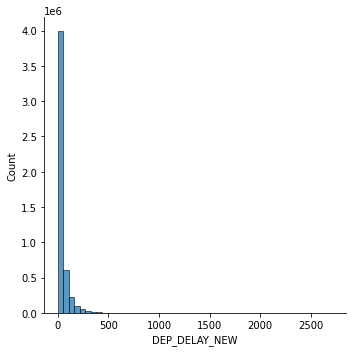

<seaborn.axisgrid.FacetGrid at 0x7f2bca6e8cd0>

In [ ]:
# check delay distribution
df_dist = df_airlines_1y.select(F.col('DEP_DELAY_NEW')).filter(F.col('DEP_DELAY_NEW')>0).toPandas()
sns.displot(df_dist, x="DEP_DELAY_NEW", bins=50)

<b>Comment:</b> The distribution of the delay time is very skewed.

In [ ]:
# analyze op_carrier delay
df1 = sqlContext.sql('''SELECT OP_UNIQUE_CARRIER, 
    sum(if(CARRIER_DELAY >0, 1, 0)) CARRIER_DELAY_COUNT, 
    sum(if(WEATHER_DELAY >0, 1, 0)) WEATHER_DELAY_COUNT, 
    sum(if(NAS_DELAY >0, 1, 0)) NAS_DELAY_COUNT, 
    sum(if(SECURITY_DELAY >0, 1, 0)) SECURITY_DELAY_COUNT, 
    sum(if(LATE_AIRCRAFT_DELAY >0, 1, 0)) LATE_AIRCRAFT_DELAY_COUNT, 
    SUM (DEP_DEL15)/COUNT(1)*100 DEP_DEL15_PERCENT
    FROM airlines group by OP_UNIQUE_CARRIER ''')

display(df1)

OP_UNIQUE_CARRIER CARRIER_DELAY_COUNT WEATHER_DELAY_COUNT NAS_DELAY_COUNT SECURITY_DELAY_COUNT LATE_AIRCRAFT_DELAY_COUNT DEP_DEL15_PERCENT UA 106628 19918 161538 88 121902 19.309165854515825 NK 31334 3714 58172 650 23702 18.2943200956821 AA 217234 25408 210406 1648 196032 19.60949580470988 EV 25466 2310 43490 0 29522 20.94473690072244 B6 99924 3996 76378 576 81528 25.39112541230822 DL 146178 18826 164668 298 119596 14.356553419100674 OO 102474 22948 157048 688 167868 17.172916330422204 F9 35798 1922 38932 0 35112 25.389728720774958 YV 39836 7462 33552 342 44782 18.716650284350205 MQ 52492 15038 82450 324 74324 17.436323993064367 OH 56236 9450 55426 552 68594 18.624007963941043 HA 16208 1362 716 332 8008 8.596869747648734 G4 17590 4414 23860 334 24756 19.001946726176342 YX 41148 6896 82736 320 60996 15.995187589814947 AS 30494 2850 64666 600 34646 15.850250740136548 WN 295772 12448 186842 2272 300520 20.225874044866877 9E 34614 5512 49590 38 48838 16.61092357232861

In [ ]:
display(df1)

OP_UNIQUE_CARRIER CARRIER_DELAY_COUNT WEATHER_DELAY_COUNT NAS_DELAY_COUNT SECURITY_DELAY_COUNT LATE_AIRCRAFT_DELAY_COUNT DEP_DEL15_PERCENT UA 106628 19918 161538 88 121902 19.309165854515825 NK 31334 3714 58172 650 23702 18.2943200956821 AA 217234 25408 210406 1648 196032 19.60949580470988 EV 25466 2310 43490 0 29522 20.94473690072244 B6 99924 3996 76378 576 81528 25.39112541230822 DL 146178 18826 164668 298 119596 14.356553419100674 OO 102474 22948 157048 688 167868 17.172916330422204 F9 35798 1922 38932 0 35112 25.389728720774958 YV 39836 7462 33552 342 44782 18.716650284350205 MQ 52492 15038 82450 324 74324 17.436323993064367 OH 56236 9450 55426 552 68594 18.624007963941043 HA 16208 1362 716 332 8008 8.596869747648734 G4 17590 4414 23860 334 24756 19.001946726176342 YX 41148 6896 82736 320 60996 15.995187589814947 AS 30494 2850 64666 600 34646 15.850250740136548 WN 295772 12448 186842 2272 300520 20.225874044866877 9E 34614 5512 49590 38 48838 16.61092357232861

<b>Comment:</b> There are five cause of delay (carrier, late aircraft, security, weather, nas). It is surprising that the weather delay is only a some portion. Most of the delay are related to carrier and late aircraft. HA among all the airline has the most of the delay are due to carrier delay but but we will look at the ratio of delay and non delay flight, HA has the smallest ratio.

In [ ]:
# delay by month 
df_month = sqlContext.sql('''SELECT MONTH, 
    sum(if(CARRIER_DELAY  >0, 1, 0)) CARRIER_DELAY_COUNT, 
    sum(if(WEATHER_DELAY  >0, 1, 0)) WEATHER_DELAY_COUNT, 
    sum(if(NAS_DELAY  >0, 1, 0)) NAS_DELAY_COUNT, 
    sum(if(SECURITY_DELAY  >0, 1, 0)) SECURITY_DELAY_COUNT, 
    sum(if(LATE_AIRCRAFT_DELAY  >0, 1, 0)) LATE_AIRCRAFT_DELAY_COUNT, 
    SUM (DEP_DEL15) DEP_DEL15_COUNT,
    AVG (DEP_DELAY_NEW) AVG_DEP_DELAY
    FROM airlines group by MONTH ''')

pd_month=df_month.toPandas()

In [ ]:
pd_month1 = pd_month.set_index(['MONTH'])

Out[19]:

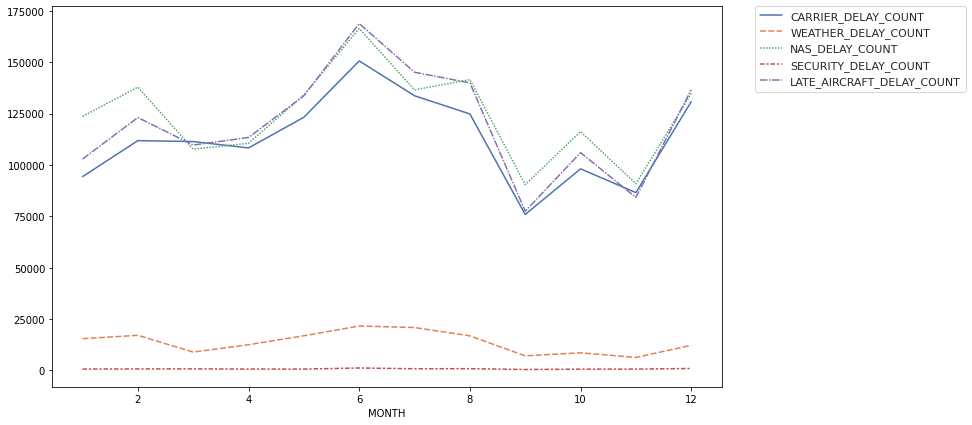

<matplotlib.legend.Legend at 0x7f2b944c18e0>

In [ ]:
# seasonal graph of various delay reasons
fig, ax = plt.subplots(figsize=(12, 7))
sns.set_theme(style="ticks")
sns.lineplot( data=pd_month1.iloc[:,:5])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


No handles with labels found to put in legend.
Out[132]:

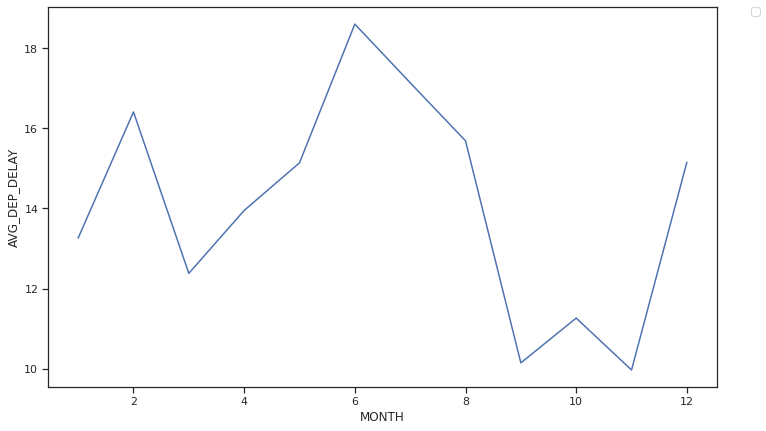

<matplotlib.legend.Legend at 0x7f4f0993e8e0>

In [ ]:
# average departure delay by month
fig, ax = plt.subplots(figsize=(12, 7))
sns.set_theme(style="ticks")
sns.lineplot( data=pd_month1.iloc[:,6])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
# delay by hour 
df=df_airlines_1y.withColumn('crs_dep_hour', F.format_string("%04d", F.col('CRS_DEP_TIME').cast('int')).substr(1, 2).cast('float'))
df.registerTempTable("hour_airline")
df_hour = sqlContext.sql('''SELECT crs_dep_hour, 
    sum(if(CARRIER_DELAY  >0, 1, 0)) CARRIER_DELAY_COUNT, 
    sum(if(WEATHER_DELAY  >0, 1, 0)) WEATHER_DELAY_COUNT, 
    sum(if(NAS_DELAY  >0, 1, 0)) NAS_DELAY_COUNT, 
    sum(if(SECURITY_DELAY  >0, 1, 0)) SECURITY_DELAY_COUNT, 
    sum(if(LATE_AIRCRAFT_DELAY  >0, 1, 0)) LATE_AIRCRAFT_DELAY_COUNT, 
    SUM (DEP_DEL15) DEP_DEL15_COUNT,
    AVG (DEP_DELAY_NEW) AVG_DEP_DELAY
    FROM hour_airline group by crs_dep_hour ''')

pd_month=df_hour.toPandas()

/databricks/spark/python/pyspark/sql/dataframe.py:146: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
 warnings.warn(

In [ ]:
pd_hour = pd_month.set_index(['crs_dep_hour'])

Out[22]:

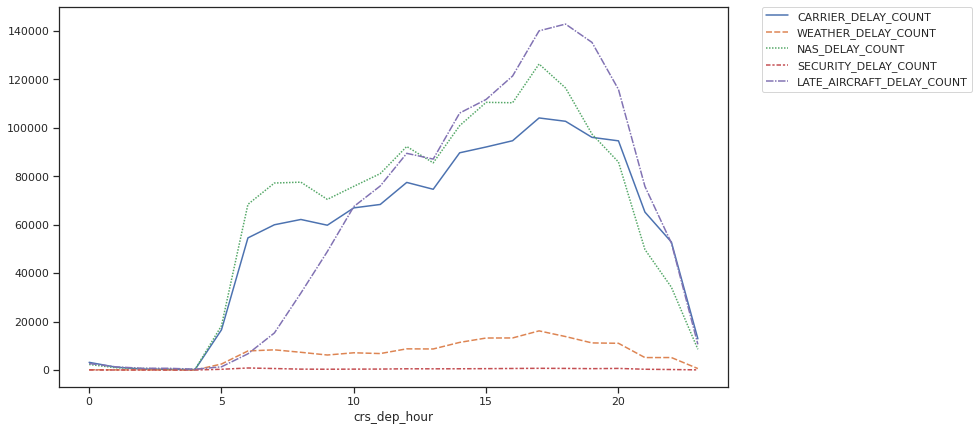

<matplotlib.legend.Legend at 0x7f2b944d5940>

In [ ]:
# delayed reasons by hour
fig, ax = plt.subplots(figsize=(12, 7))
sns.set_theme(style="ticks")
sns.lineplot( data=pd_hour.iloc[:,:5])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


<b>Comment:</b> When we breakdown by month and hour, can see that there is a strong seasonality to the delay. Most of the delay happens between June and August, and in December. Those are holiday seasons so we expect a lot of people are travelling. While we break down to hourly view, we can see that the delays counts starting to rise about 6 and reached its peak around 18 (6pm).

In [ ]:
# delay by airpot 
df_airpot = sqlContext.sql('''SELECT ORIGIN, DEST,
    sum(if(CARRIER_DELAY >0, 1, 0)) CARRIER_DELAY_COUNT, 
    sum(if(WEATHER_DELAY >0, 1, 0)) WEATHER_DELAY_COUNT, 
    sum(if(NAS_DELAY >0, 1, 0)) NAS_DELAY_COUNT, 
    sum(if(SECURITY_DELAY >0, 1, 0)) SECURITY_DELAY_COUNT, 
    sum(if(LATE_AIRCRAFT_DELAY >0, 1, 0)) LATE_AIRCRAFT_DELAY_COUNT, 
    SUM (DEP_DEL15) DEP_DEL15_COUNT,
    AVG (DEP_DELAY_NEW) AVG_DEP_DELAY,
    count(*) COUNTS
    FROM airlines group by ORIGIN,DEST ''')

In [ ]:
df_airpot.toPandas().groupby(by =['ORIGIN']).sum().sort_values(by = ['COUNTS'],ascending = False).iloc[:,7].head(10)

Out[135]: ORIGIN
ATL 790018
ORD 679212
DFW 608688
DEN 504052
CLT 470992
LAX 439904
IAH 359376
PHX 350656
LGA 343330
SFO 341836
Name: COUNTS, dtype: int64

In [ ]:
df_airpot.toPandas().sort_values(by = ['DEP_DEL15_COUNT'],ascending = False).head(10)

Out[136]:

ORIGIN 
 DEST 
 CARRIER_DELAY_COUNT 
 WEATHER_DELAY_COUNT 
 NAS_DELAY_COUNT 
 SECURITY_DELAY_COUNT 
 LATE_AIRCRAFT_DELAY_COUNT 
 DEP_DEL15_COUNT 
 AVG_DEP_DELAY 
 COUNTS 
 
 
 
 
 3092 
 ORD 
 LGA 
 2502 
 918 
 6674 
 4 
 4002 
 8022.0 
 24.095612 
 29404 
 
 
 4423 
 LGA 
 ORD 
 2228 
 564 
 5782 
 6 
 4226 
 6940.0 
 23.204207 
 29398 
 
 
 3310 
 LAX 
 SFO 
 1752 
 20 
 4690 
 6 
 3036 
 6742.0 
 17.231615 
 29260 
 
 
 4864 
 SFO 
 LAX 
 2272 
 40 
 3622 
 16 
 3628 
 5780.0 
 14.703478 
 29228 
 
 
 2086 
 LAX 
 JFK 
 2518 
 42 
 2798 
 12 
 1718 
 5128.0 
 15.590827 
 25724 
 
 
 3380 
 BOS 
 LGA 
 1624 
 252 
 3712 
 0 
 2732 
 5122.0 
 22.532579 
 20606 
 
 
 6217 
 LGA 
 BOS 
 2290 
 248 
 3296 
 6 
 3520 
 5052.0 
 21.380463 
 20618 
 
 
 2807 
 MCO 
 EWR 
 1266 
 270 
 3346 
 12 
 1654 
 4626.0 
 32.324253 
 13818 
 
 
 2415 
 SEA 
 SFO 
 1078 
 114 
 3356 
 2 
 1552 
 4506.0 
 17.932658 
 18624 
 
 
 319 
 ATL 
 LGA 
 1626 
 142 
 3234 
 14 
 1748 
 4482.0 
 16.628632 
 19030

<b>Comment:</b> The flights between ORD and LGA have the most delay. As we can see ORD, LGA, SFO, and LAX are the top 10 busiest airport. So it is clean that there is so correlation between the business of the airport and the delay

### EDA: Weather Data

<b>Comment:</b> After cleaning the data, feature engineering, and aggregation, the final weather dataset is reduced down to 104.3M rows and 11 columns

In [ ]:
weather_metar_df = spark.read.parquet(f"{blob_url}/weather_cleaned_1_hour_agg")
display(weather_metar_df)

weather_station weather_station_name metar_hour avg_hourly_dew_point_temp avg_hourly_dry_bulb_temp avg_hourly_relative_humidity avg_hourly_station_pressure avg_hourly_visibility avg_hourly_wind_direction avg_hourly_wind_speed avg_hourly_precipitation_ordinal 72036163870 FLORALA MUNICIPAL AIRPORT, AL US 2020-01-02T20:00:00.000+0000 68.0 73.0 84.0 29.545000076293945 9.0 195.0 14.5 0.0 72036163870 FLORALA MUNICIPAL AIRPORT, AL US 2020-01-05T21:00:00.000+0000 36.0 39.0 89.0 29.969999313354492 10.0 190.0 3.0 0.0 72036163870 FLORALA MUNICIPAL AIRPORT, AL US 2020-01-10T11:00:00.000+0000 58.0 70.5 64.5 29.950000762939453 10.0 170.0 9.0 0.0 72486023154 ELY AIRPORT, NV US 2020-01-04T00:00:00.000+0000 17.0 24.0 75.0 24.040000915527344 10.0 0.0 0.0 0.0 72225353992 BASTROP MOREHOUSE MEMORIAL AIRPORT, LA US 2020-01-08T15:00:00.000+0000 28.666666666666668 63.666666666666664 26.666666666666668 30.146666208902996 10.0 150.0 7.0 0.0 72225353992 BASTROP MOREHOUSE MEMORIAL AIRPORT, LA US 2020-01-09T05:00:00.000+0000 38.0 45.666666666666664 75.33333333333333 30.06999969482422 10.0 110.0 4.333333333333333 0.0 72225353992 BASTROP MOREHOUSE MEMORIAL AIRPORT, LA US 2020-01-10T14:00:00.000+0000 64.33333333333333 72.66666666666667 74.33333333333333 29.760000228881836 10.0 160.0 8.0 0.0 70360525604 PLATINUM AIRPORT, AK US 2020-01-07T09:00:00.000+0000 -14.0 -10.0 81.0 29.989999771118164 10.0 30.0 8.0 0.0 70360525604 PLATINUM AIRPORT, AK US 2020-01-08T08:00:00.000+0000 -13.0 -9.0 82.0 30.0 10.0 60.0 13.0 0.0 72235703961 NATCHEZ ADAM CO AIRPORT, MS US 2020-01-05T10:00:00.000+0000 40.0 60.0 47.0 30.09000015258789 10.0 190.0 8.0 0.0 72235703961 NATCHEZ ADAM CO AIRPORT, MS US 2020-01-10T11:00:00.000+0000 64.5 71.5 79.5 29.780000686645508 10.0 155.0 12.0 0.0 99999900440 CULLMAN REGIONAL AIRPORT FOLSOM FIELD, AL US 2020-01-04T17:00:00.000+0000 25.0 36.333333333333336 63.333333333333336 29.196666717529297 10.0 323.3333333333333 6.666666666666667 0.0 74000154793 SUSSEX AIRPORT, NJ US 2020-01-03T08:00:00.000+0000 37.0 41.0 86.0 29.3700008392334 6.0 0.0 0.0 0.0 74000154793 SUSSEX AIRPORT, NJ US 2020-01-06T13:00:00.000+0000 29.0 40.0 65.0 29.440000534057617 10.0 null 6.0 0.0 74000154793 SUSSEX AIRPORT, NJ US 2020-01-10T12:00:00.000+0000 31.0 41.0 67.0 29.969999313354492 10.0 210.0 9.0 0.0 71867099999 THE PAS AIRPORT, CA 2020-01-03T03:00:00.000+0000 22.6 23.8 95.8 null 7.833333333333333 233.33333333333334 3.6 0.0 71867099999 THE PAS AIRPORT, CA 2020-01-06T14:00:00.000+0000 9.0 12.0 85.0 null 9.0 290.0 15.0 0.0 72768094008 GLASGOW INTERNATIONAL AIRPORT, MT US 2020-01-01T23:00:00.000+0000 26.75 29.75 88.25 27.077499866485596 2.25 262.5 6.5 0.0 72398093720 SALISBURY WICOMICO REGIONAL AIRPORT, MD US 2020-01-06T05:00:00.000+0000 28.0 33.0 82.0 29.93000030517578 10.0 0.0 0.0 0.0 72221312819 LEESBURG MUNICIPAL AIRPORT, FL US 2020-01-03T21:00:00.000+0000 67.0 77.0 71.0 29.979999542236328 10.0 200.0 7.0 0.0 72616654781 BENNINGTON MORSE STATE AIRPORT, VT US 2020-01-04T15:00:00.000+0000 38.5 41.5 89.25 28.652499675750732 2.1875 85.0 0.75 0.0 72616654781 BENNINGTON MORSE STATE AIRPORT, VT US 2020-01-08T19:00:00.000+0000 4.0 23.0 44.0 29.229999542236328 10.0 290.0 14.0 0.0 72616654781 BENNINGTON MORSE STATE AIRPORT, VT US 2020-01-10T03:00:00.000+0000 9.0 29.0 43.0 29.559999465942383 10.0 110.0 7.0 0.0 72222313899 PENSACOLA REGIONAL AIRPORT, FL US 2020-01-01T22:00:00.000+0000 56.0 61.0 84.0 29.889999389648438 10.0 140.0 5.0 0.0 72222313899 PENSACOLA REGIONAL AIRPORT, FL US 2020-01-07T20:00:00.000+0000 31.0 50.0 48.0 30.219999313354492 10.0 340.0 6.0 0.0 70063427408 UGNU KUPARUK AIRPORT, AK US 2020-01-02T05:00:00.000+0000 -18.0 -15.0 83.0 30.15999984741211 10.0 50.0 13.0 0.0 70063427408 UGNU KUPARUK AIRPORT, AK US 2020-01-03T14:00:00.000+0000 -33.0 -20.0 51.0 30.280000686645508 10.0 30.0 11.0 0.0 72747694961 BAUDETTE INTERNATIONAL AIRPORT, MN US 2020-01-01T03:00:00.000+0000 6.0 9.0 88.0 28.170000076293945 10.0 170.0 9.0 0.0 72747694961 BAUDETTE INTERNATIONAL AIRPORT, MN US 2020-01-0

More EDA on weather data: https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/4236430293323588/command/148077048170798

### EDA: Station Data

In [ ]:
df_station.display()

usaf wban station_id lat lon neighbor_id neighbor_name neighbor_state neighbor_call neighbor_lat neighbor_lon distance_to_neighbor 690020 93218 69002093218 36.0 -121.233 69002093218 JOLON HUNTER LIGGETT MIL RES CA KHGT 36.0 -121.233 0.0 690020 93218 69002093218 36.0 -121.233 69007093217 FRITZSCHE AAF CA KOAR 36.683 -121.767 55.73024537916726 690020 93218 69002093218 36.0 -121.233 69014093101 EL TORO MCAS CA KNZJ 33.667 -117.733 255.49106220353934 690020 93218 69002093218 36.0 -121.233 70027127506 BARROW POINT BARROW AK KPBA 71.333 -156.65 2750.4353299559803 690020 93218 69002093218 36.0 -121.233 70045027512 LONELY AK LNI 70.917 -153.25 2676.3554370627153 690020 93218 69002093218 36.0 -121.233 70063027403 OLIKTOK POW 2 AK POLI 70.5 -149.883 2604.050248854232 690020 93218 69002093218 36.0 -121.233 70063526465 GALBRAITH LAKE AIRPORT AK PAGB 68.479 -149.49 2490.9756094472277 690020 93218 69002093218 36.0 -121.233 70063627405 PRUDHOE BAY AK PAUD 70.25 -148.333 2568.180281844432 690020 93218 69002093218 36.0 -121.233 70104626418 CENTRAL AIRPORT AK PACE 65.567 -144.765 2254.5584891291946 690020 93218 69002093218 36.0 -121.233 70119526625 SHISHMAREF/NEW AIRPORT AK PASH 66.25 -166.089 2743.6881828292408 690020 93218 69002093218 36.0 -121.233 70121326638 POINT LAY LIZ 2 AK PIZ 69.733 -163.017 2796.6187763021226 690020 93218 69002093218 36.0 -121.233 70148626642 KIVALINA AIRPORT AK PAVL 67.732 -164.548 2755.8847615355235 690020 93218 69002093218 36.0 -121.233 70162026508 UMIAT AK PAUM 69.367 -152.133 2580.421414177685 690020 93218 69002093218 36.0 -121.233 70171900490 SHUNGNAK AIRPORT AK PAGH 66.888 -157.162 2560.459862643483 690020 93218 69002093218 36.0 -121.233 70174526480 CHANDALAR LAKE AIRPORT AK PALR 67.511 -148.493 2423.3408124753164 690020 93218 69002093218 36.0 -121.233 70179326524 MANLEY HOT SPRINGS AK PAML 64.999 -150.638 2336.6091618691917 690020 93218 69002093218 36.0 -121.233 70199526628 CAPE DARBY REMOT COM OUTLT AK PAGL 64.55 -163.007 2610.7849480759573 690020 93218 69002093218 36.0 -121.233 70206026632 NORTHEAST CAPE AK KOHC 63.317 -168.967 2740.2899674712785 690020 93218 69002093218 36.0 -121.233 70222326602 KOYUK AIRPORT AK PAKK 64.935 -161.155 2576.6261990332778 690020 93218 69002093218 36.0 -121.233 70231226555 FAREWELL LAKE SEAPLANE BASE AK PAFK 62.543 -153.623 2293.7430034471354 690020 93218 69002093218 36.0 -121.233 70249526547 HAYES RIVER AIRPORT AK PAHZ 61.983 -152.083 2230.946084519868 690020 93218 69002093218 36.0 -121.233 70255026514 SKWENTNA AIRPORT AK PASW 61.977 -151.217 2209.0623964277706 690020 93218 69002093218 36.0 -121.233 70264026414 SUMMIT AK PAST 63.331 -149.127 2223.352307308065 690020 93218 69002093218 36.0 -121.233 70264726499 HEALY RIVER AIRPORT AK PAHV 63.866 -148.969 2246.1213363715397 690020 93218 69002093218 36.0 -121.233 70264846406 CANTWELL AIRPORT AK PATW 63.391 -148.956 2222.52653340686 690020 93218 69002093218 36.0 -121.233 70267526484 PAXSON AIRPORT AK PAXK 63.032 -145.498 2131.3748228756726 690020 93218 69002093218 36.0 -121.233 70269596402 JONESVILLE MINE AIRPORT AK PAJV 61.714 -148.909 2140.8509123873396 690020 93218 69002093218 36.0 -121.233 70271126439 SHEEP MOUNTAIN AIRPORT AK PASP 61.812 -147.507 2112.749500893187 690020 93218 69002093218 36.0 -121.233 70274526560 WILLOW AIRPORT AK PAUO 61.748 -150.054 2170.093644623675 690020 93218 69002093218 36.0 -121.233 70275026442 NATIONAL WEATHER SERVICE OFFI AK PAVW 61.13 -146.352 2052.4465612834106 690020 93218 69002093218 36.0 -121.233 70275546404 MCCARTHY AIRPORT AK PAMX 61.437 -142.904 1993.3299561949077 690020 93218 69002093218 36.0 -121.233 70275726444 WHITTIER AIRPORT AK PAWR 60.783 -148.733 2092.9535147837305 690020 93218 69002093218 36.0 -121.233 70291346402 DEVILS MOUNTAIN LODGE AIRPORT AK PABN 62.402 -142.995 2047.8132237563839 690020 93218 69002093218 36.0 -121.233 70291526486 DUFFY'S TAVERN AIRPORT AK PADT 62.709 -143.981 2083.812325469856 690020 93218 69002093218 36.0 -121.233 70292326440 TANACROSS AK TSG 63.383 -143.333 2

In [ ]:
df_station.printSchema()

root
-- usaf: string (nullable = true)
-- wban: string (nullable = true)
-- station_id: string (nullable = true)
-- lat: double (nullable = true)
-- lon: double (nullable = true)
-- neighbor_id: string (nullable = true)
-- neighbor_name: string (nullable = true)
-- neighbor_state: string (nullable = true)
-- neighbor_call: string (nullable = true)
-- neighbor_lat: double (nullable = true)
-- neighbor_lon: double (nullable = true)
-- distance_to_neighbor: double (nullable = true)

In [ ]:
print(df_station.count(), len(df_station.columns))

5004169 12

<b>Comment:</b> There are a total of 5,004,169 rows in the stations dataset.

In [ ]:
# check missing data percentages
count_missings(df_station)

Out[12]:

count 
 
 
 
 
 usaf 
 0.0 
 
 
 wban 
 0.0 
 
 
 station_id 
 0.0 
 
 
 lat 
 0.0 
 
 
 lon 
 0.0 
 
 
 neighbor_id 
 0.0 
 
 
 neighbor_name 
 0.0 
 
 
 neighbor_state 
 0.0 
 
 
 neighbor_call 
 0.0 
 
 
 neighbor_lat 
 0.0 
 
 
 neighbor_lon 
 0.0 
 
 
 distance_to_neighbor 
 0.0

<b>Comment:</b> There are no missing data in the stations dataset.

In [ ]:
station_agg = df_station.groupby("station_id", "lat", "lon").count()
station_agg.display()

station_id lat lon count 72034354852 44.333 -89.02 2237 72037492825 27.916 -82.449 2237 72209653127 35.976 -115.133 2237 72288023152 34.201 -118.358 2237 72329003935 37.225 -89.571 2237 72476593013 38.506 -107.899 2237 72486023154 39.295 -114.847 2237 72646454834 43.167 -88.717 2237 74704003102 34.056 -117.6 2237 72033493764 39.167 -77.167 2237 72353653986 36.383 -97.8 2237 72522014750 43.338 -73.61 2237 70275546404 61.437 -142.904 2237 72310813776 34.608 -79.059 2237 72656394969 44.333 -93.317 2237 70305800110 56.017 -161.167 2237 72029703730 37.239 -76.716 2237 72218204890 41.893 -89.078 2237 72290303131 32.816 -117.139 2237 72293193107 32.867 -117.133 2237 72483793216 39.133 -121.433 2237 74509023244 37.406 -122.048 2237 72519014771 43.111 -76.104 2237 74207703763 36.437 -79.851 2237 78514011603 18.498 -67.129 2237 70117026634 65.563 -167.921 2237 72073400264 43.581 -116.523 2237 72375003103 35.144 -111.666 2237 72436313803 39.267 -85.9 2237 72551014939 40.851 -96.748 2237 74768853858 30.464 -88.532 2237 72528704724 43.108 -78.938 2237 72307513769 36.817 -76.033 2237 70305726653 60.541 -165.087 2237 70326025503 58.683 -156.656 2237 70364427515 70.212 -151.002 2237 72058900185 44.783 -88.55 2237 72104800471 29.634 -104.361 2237 72261022010 29.378 -100.927 2237 72265623040 31.78 -103.202 2237 72323513896 34.744 -87.6 2237 72381023114 34.9 -117.867 2237 72423853886 37.8 -87.683 2237 72492023237 37.889 -121.226 2237 72575024126 41.196 -112.011 2237 72598524267 42.074 -124.29 2237 91182022521 21.324 -157.929 2237 72042600141 37.158 -95.778 2237 70361025339 59.512 -139.671 2237 72026654809 41.275 -85.84 2237 72035923902 35.275 -96.675 2237 72047600455 39.725 -91.444 2237 72071400252 33.912 -84.941 2237 72257503972 31.083 -97.683 2237 72469400450 39.784 -104.538 2237 72549404966 41.01 -95.26 2237 72698824219 45.619 -121.166 2237 72792024227 46.973 -122.903 2237 72267703027 35.003 -105.663 2237 72607994601 44.067 -69.1 2237 70019726558 66.6 -159.986 2237 70086027401 70.134 -143.577 2237 72428704848 41.563 -83.476 2237 72464093058 38.29 -104.498 2237 72534804831 41.604 -88.085 2237 72538694898 44.022 -82.793 2237 72667904969 45.698 -92.953 2237 72073800267 30.902 -83.881 2237 72292023191 33.405 -118.416 2237 72355013945 34.65 -98.4 2237 72523504720 42.15 -79.25 2237 72096400338 30.033 -85.533 2237 72206953853 30.4 -86.472 2237 72228013876 33.566 -86.745 2237 72382523131 34.583 -117.383 2237 72643894994 43.156 -90.678 2237 72745404911 47.838 -90.383 2237 72053900165 37.283 -107.05 2237 72202612826 25.483 -80.383 2237 72209003875 31.883 -81.567 2237 72408013739 39.873 -75.227 2237 72467793007 38.533 -106.933 2237 72501654790 40.822 -72.869 2237 74796012804 27.65 -81.333 2237 72228713871 33.587 -85.856 2237 72235413927 32.337 -90.221 2237 72248713935 31.395 -92.291 2237 72438814829 41.533 -85.783 2237 72555694975 42.577 -100.001 2237 72565003017 39.833 -104.658 2237 72309893798 38.527 -77.859 2237 72654614946 44.905 -97.149 2237 70306125521 59.324 -155.902 2237 72032204129 48.299 -116.56 2237 72033353175 33.898 -117.602 2237 72272093026 31.458 -109.606 2237 72293453121 33.219 -117.349 2237 72295023174 33.938 -118.389 2237 72546014933 41.534 -93.653 2237 72562594040 40.206 -100.591 2237 74788012810 27.85 -82.517 2237 74791700390 32.9 -79.783 2237 A0705600464 44.874 -87.91 2237 72051724165 41.824 -110.557 2237 72221800356 38.533 -76.033 2237 72262023055 31.831 -104.809 2237 72311403715 38.01 -77.97 2237 72747404923 47.424 -92.498 2237 72066600244 28.6 -91.2 2237 72578724158 42.017 -113.25 2237 72030553964 33.254 -97.581 2237 72246953912 32.031 -96.399 2237 72334013893 35.056 -89.987 2237 72656204943 44.628 -93.228 2237 72783024149 46.375 -117.016 2237 74718823158 33.619 -114.714 2237 74780413824 32.017 -81.133 2237 72060800200 34.181 -79.335 2237 72309793743 34.683 -77.033 2237 72311553854 33.462 -80.858 2237 72515594761 42.483 -76.467 2237 70264846406 63.391 -148.956 2237 72066500243 27.2 -92.2 2237 72248513944 32.5 -93.667 2237 7226702

In [ ]:
#2237 unique stations, each station has 2237 neighbors 
print(station_agg.count(), len(station_agg.columns))

2237 4

In [ ]:
lon = station_agg.select('lon').rdd.flatMap(lambda x: x).collect()
lat = station_agg.select('lat').rdd.flatMap(lambda x: x).collect()

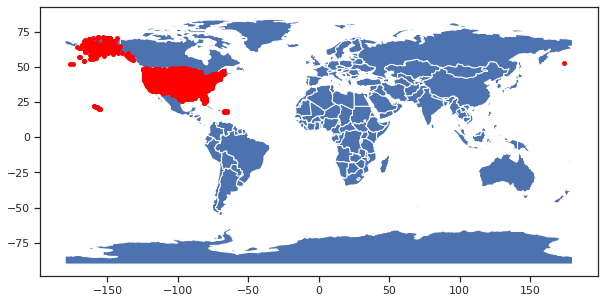

In [ ]:
geometry = [Point(xy) for xy in zip(lon, lat)]
gdf = GeoDataFrame(station_agg.toPandas(), geometry=geometry)   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

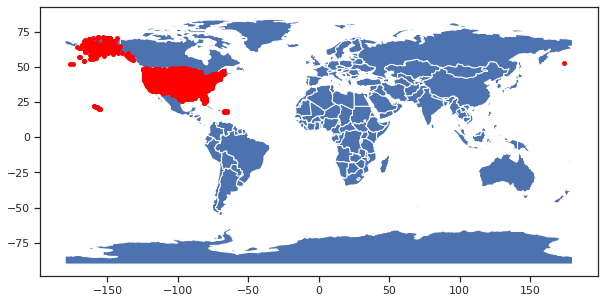

In [ ]:
pd_station = df_station.groupby("neighbor_id", "neighbor_lat", "neighbor_lon").count().toPandas()
geometry = [Point(xy) for xy in zip(pd_station["neighbor_lon"], pd_station["neighbor_lat"])]
gdf = GeoDataFrame(pd_station, geometry=geometry)   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

### EDA: Airport Data

In [ ]:
#Downloaded from https://openflights.org/data.html
airports = spark.read.csv("/airports.dat", header=False, inferSchema=True)
display(airports)

_c0 _c1 _c2 _c3 _c4 _c5 _c6 _c7 _c8 _c9 _c10 _c11 _c12 _c13 1 Goroka Airport Goroka Papua New Guinea GKA AYGA -6.081689834590001 145.391998291 5282 10 U Pacific/Port_Moresby airport OurAirports 2 Madang Airport Madang Papua New Guinea MAG AYMD -5.20707988739 145.789001465 20 10 U Pacific/Port_Moresby airport OurAirports 3 Mount Hagen Kagamuga Airport Mount Hagen Papua New Guinea HGU AYMH -5.826789855957031 144.29600524902344 5388 10 U Pacific/Port_Moresby airport OurAirports 4 Nadzab Airport Nadzab Papua New Guinea LAE AYNZ -6.569803 146.725977 239 10 U Pacific/Port_Moresby airport OurAirports 5 Port Moresby Jacksons International Airport Port Moresby Papua New Guinea POM AYPY -9.443380355834961 147.22000122070312 146 10 U Pacific/Port_Moresby airport OurAirports 6 Wewak International Airport Wewak Papua New Guinea WWK AYWK -3.58383011818 143.669006348 19 10 U Pacific/Port_Moresby airport OurAirports 7 Narsarsuaq Airport Narssarssuaq Greenland UAK BGBW 61.1604995728 -45.4259986877 112 -3 E America/Godthab airport OurAirports 8 Godthaab / Nuuk Airport Godthaab Greenland GOH BGGH 64.19090271 -51.6781005859 283 -3 E America/Godthab airport OurAirports 9 Kangerlussuaq Airport Sondrestrom Greenland SFJ BGSF 67.0122218992 -50.7116031647 165 -3 E America/Godthab airport OurAirports 10 Thule Air Base Thule Greenland THU BGTL 76.5311965942 -68.7032012939 251 -4 E America/Thule airport OurAirports 11 Akureyri Airport Akureyri Iceland AEY BIAR 65.66000366210938 -18.07270050048828 6 0 N Atlantic/Reykjavik airport OurAirports 12 Egilsstaðir Airport Egilsstadir Iceland EGS BIEG 65.2833023071289 -14.401399612426758 76 0 N Atlantic/Reykjavik airport OurAirports 13 Hornafjörður Airport Hofn Iceland HFN BIHN 64.295601 -15.2272 24 0 N Atlantic/Reykjavik airport OurAirports 14 Húsavík Airport Husavik Iceland HZK BIHU 65.952301 -17.426001 48 0 N Atlantic/Reykjavik airport OurAirports 15 Ísafjörður Airport Isafjordur Iceland IFJ BIIS 66.05809783935547 -23.135299682617188 8 0 N Atlantic/Reykjavik airport OurAirports 16 Keflavik International Airport Keflavik Iceland KEF BIKF 63.985000610352 -22.605600357056 171 0 N Atlantic/Reykjavik airport OurAirports 17 Patreksfjörður Airport Patreksfjordur Iceland PFJ BIPA 65.555801 -23.965 11 0 N Atlantic/Reykjavik airport OurAirports 18 Reykjavik Airport Reykjavik Iceland RKV BIRK 64.1299972534 -21.9405994415 48 0 N Atlantic/Reykjavik airport OurAirports 19 Siglufjörður Airport Siglufjordur Iceland SIJ BISI 66.133301 -18.9167 10 0 N Atlantic/Reykjavik airport OurAirports 20 Vestmannaeyjar Airport Vestmannaeyjar Iceland VEY BIVM 63.42430114746094 -20.278900146484375 326 0 N Atlantic/Reykjavik airport OurAirports 21 Sault Ste Marie Airport Sault Sainte Marie Canada YAM CYAM 46.48500061035156 -84.5093994140625 630 -5 A America/Toronto airport OurAirports 22 Winnipeg / St. Andrews Airport Winnipeg Canada \N CYAV 50.0564002991 -97.03250122070001 760 -6 A America/Winnipeg airport OurAirports 23 Halifax / CFB Shearwater Heliport Halifax Canada \N CYAW 44.639702 -63.499401 144 -4 A America/Halifax airport OurAirports 24 St. Anthony Airport St. Anthony Canada YAY CYAY 51.3918991089 -56.083099365200006 108 -3.5 A America/St_Johns airport OurAirports 25 Tofino / Long Beach Airport Tofino Canada YAZ CYAZ 49.079833 -125.775583 80 -8 A America/Vancouver airport OurAirports 26 Kugaaruk Airport Pelly Bay Canada YBB CYBB 68.534401 -89.808098 56 -7 A America/Edmonton airport OurAirports 27 Baie Comeau Airport Baie Comeau Canada YBC CYBC 49.13249969482422 -68.20439910888672 71 -5 A America/Toronto airport OurAirports 28 CFB Bagotville Bagotville Canada YBG CYBG 48.33060073852539 -70.99639892578125 522 -5 A America/Toronto airport OurAirports 29 Baker Lake Airport Baker Lake Canada YBK CYBK 64.29889678960001 -96.077796936 59 -6 A America/Winnipeg airport OurAirports 30 Campbell River Airport Campbell River Canada YBL CYBL 49.950801849365234 -125.27100372314453 346 -8 A America/Vancouver airport OurAirports 31 Brandon Municipal Ai

In [ ]:
print("Total distinct airports:", airports.select("_c1").distinct().count())

Total distinct airports: 7658

In [ ]:
print(airports.count(), len(airports.columns))

7698 14

In [ ]:
airports.select("_c3").distinct().collect()

Out[13]: [Row(_c3='Chad'),
 Row(_c3='Paraguay'),
 Row(_c3='Anguilla'),
 Row(_c3='Russia'),
 Row(_c3='British Indian Ocean Territory'),
 Row(_c3='Yemen'),
 Row(_c3='Senegal'),
 Row(_c3='Sweden'),
 Row(_c3='Kiribati'),
 Row(_c3='Guyana'),
 Row(_c3='Jersey'),
 Row(_c3='Philippines'),
 Row(_c3='Burma'),
 Row(_c3='Eritrea'),
 Row(_c3='Tonga'),
 Row(_c3='Norfolk Island'),
 Row(_c3='Djibouti'),
 Row(_c3='Malaysia'),
 Row(_c3='Singapore'),
 Row(_c3='Fiji'),
 Row(_c3='Turkey'),
 Row(_c3='Malawi'),
 Row(_c3='Western Sahara'),
 Row(_c3='Iraq'),
 Row(_c3='Germany'),
 Row(_c3='Northern Mariana Islands'),
 Row(_c3='Comoros'),
 Row(_c3='Afghanistan'),
 Row(_c3='Cambodia'),
 Row(_c3='Saint Helena'),
 Row(_c3='Rwanda'),
 Row(_c3='Jordan'),
 Row(_c3='Maldives'),
 Row(_c3='Sudan'),
 Row(_c3='Palau'),
 Row(_c3='France'),
 Row(_c3='Turks and Caicos Islands'),
 Row(_c3='Greece'),
 Row(_c3='Sri Lanka'),
 Row(_c3='Montserrat'),
 Row(_c3='Taiwan'),
 Row(_c3='Dominica'),
 Row(_c3='British Virgin Islands'),
 Row(_c3='Algeria'),
 Row(_c3='Togo'),
 Row(_c3='Equatorial Guinea'),
 Row(_c3='Slovakia'),
 Row(_c3='Reunion'),
 Row(_c3='Macau'),
 Row(_c3='Argentina'),
 Row(_c3='Belgium'),
 Row(_c3='Angola'),
 Row(_c3='West Bank'),
 Row(_c3='East Timor'),
 Row(_c3='Qatar'),
 Row(_c3='Ecuador'),
 Row(_c3='Lesotho'),
 Row(_c3='Madagascar'),
 Row(_c3='Albania'),
 Row(_c3='Finland'),
 Row(_c3='New Caledonia'),
 Row(_c3='Ghana'),
 Row(_c3='Nicaragua'),
 Row(_c3='Myanmar'),
 Row(_c3='Guernsey'),
 Row(_c3='Benin'),
 Row(_c3='Sierra Leone'),
 Row(_c3='Peru'),
 Row(_c3='Bahamas'),
 Row(_c3='India'),
 Row(_c3='China'),
 Row(_c3='United States'),
 Row(_c3='Belarus'),
 Row(_c3='Malta'),
 Row(_c3='American Samoa'),
 Row(_c3='Kuwait'),
 Row(_c3='Sao Tome and Principe'),
 Row(_c3='Somalia'),
 Row(_c3='Marshall Islands'),
 Row(_c3='Tuvalu'),
 Row(_c3='Chile'),
 Row(_c3='Puerto Rico'),
 Row(_c3='Tajikistan'),
 Row(_c3='Martinique'),
 Row(_c3='Cayman Islands'),
 Row(_c3='Isle of Man'),
 Row(_c3='Croatia'),
 Row(_c3='Burundi'),
 Row(_c3='Nigeria'),
 Row(_c3='Bolivia'),
 Row(_c3='Virgin Islands'),
 Row(_c3='Gabon'),
 Row(_c3='Italy'),
 Row(_c3='Suriname'),
 Row(_c3='Netherlands Antilles'),
 Row(_c3='Lithuania'),
 Row(_c3='Norway'),
 Row(_c3='Turkmenistan'),
 Row(_c3='Spain'),
 Row(_c3='Saint Pierre and Miquelon'),
 Row(_c3='Cuba'),
 Row(_c3='Mauritania'),
 Row(_c3='Guadeloupe'),
 Row(_c3='Congo (Kinshasa)'),
 Row(_c3='Niger'),
 Row(_c3='Denmark'),
 Row(_c3='Central African Republic'),
 Row(_c3='Barbados'),
 Row(_c3='Bangladesh'),
 Row(_c3='Iran'),
 Row(_c3='Ireland'),
 Row(_c3='Svalbard'),
 Row(_c3='Swaziland'),
 Row(_c3='Laos'),
 Row(_c3='Thailand'),
 Row(_c3='Christmas Island'),
 Row(_c3='Cocos (Keeling) Islands'),
 Row(_c3='Bhutan'),
 Row(_c3='Morocco'),
 Row(_c3='Cape Verde'),
 Row(_c3='Panama'),
 Row(_c3='Hong Kong'),
 Row(_c3='Nauru'),
 Row(_c3='Venezuela'),
 Row(_c3='Ukraine'),
 Row(_c3='Iceland'),
 Row(_c3='Israel'),
 Row(_c3='Antarctica'),
 Row(_c3='Saint Kitts and Nevis'),
 Row(_c3='French Polynesia'),
 Row(_c3='Oman'),
 Row(_c3='North Korea'),
 Row(_c3='South Korea'),
 Row(_c3='Cyprus'),
 Row(_c3='Gibraltar'),
 Row(_c3='Palestine'),
 Row(_c3='Uruguay'),
 Row(_c3="Cote d'Ivoire"),
 Row(_c3='Mexico'),
 Row(_c3='Aruba'),
 Row(_c3='Estonia'),
 Row(_c3='Zimbabwe'),
 Row(_c3='Montenegro'),
 Row(_c3='Georgia'),
 Row(_c3='Indonesia'),
 Row(_c3='Saint Vincent and the Grenadines'),
 Row(_c3='Guatemala'),
 Row(_c3='Guam'),
 Row(_c3='Mongolia'),
 Row(_c3='Libya'),
 Row(_c3='Azerbaijan'),
 Row(_c3='Grenada'),
 Row(_c3='Armenia'),
 Row(_c3='Tunisia'),
 Row(_c3='Liberia'),
 Row(_c3='Honduras'),
 Row(_c3='Syria'),
 Row(_c3='Trinidad and Tobago'),
 Row(_c3='Congo (Brazzaville)'),
 Row(_c3='Saudi Arabia'),
 Row(_c3='Midway Islands'),
 Row(_c3='Uganda'),
 Row(_c3='Wallis and Futuna'),
 Row(_c3='French Guiana'),
 Row(_c3='Mayotte'),
 Row(_c3='Namibia'),
 Row(_c3='Switzerland'),
 Row(_c3='Zambia'),
 Row(_c3='Ethiopia'),
 Row(_c3='Jamaica'),
 Row(_c3='Latvia'),
 Row(_c3='South Sudan'),
 Row(_c

In [ ]:
# Rename columns with new names from data dictionary
airports = airports\
              .withColumnRenamed("_c1", "name")\
              .withColumnRenamed("_c3", "country") \
              .withColumnRenamed("_c4", "IATA")\
              .withColumnRenamed("_c5", "ICAO")\
              .withColumnRenamed("_c6", "lat")\
              .withColumnRenamed("_c7", "lon")\
              .withColumnRenamed("_c8", "Altitude")\
              .filter(F.col("_c3") == "United States")\
              .drop("_c0", "_c2", "country", "_c9", "_c10", "_c11", "_c12", "_c13")
display(airports)

name IATA ICAO lat lon Altitude Barter Island LRRS Airport BTI PABA 70.1340026855 -143.582000732 2 Wainwright Air Station \N PAWT 70.61340332 -159.8600006 35 Cape Lisburne LRRS Airport LUR PALU 68.87509918 -166.1100006 16 Point Lay LRRS Airport PIZ PPIZ 69.73290253 -163.0050049 22 Hilo International Airport ITO PHTO 19.721399307250977 -155.04800415039062 38 Orlando Executive Airport ORL KORL 28.5455 -81.332901 113 Bettles Airport BTT PABT 66.91390228 -151.529007 647 Clear Airport \N PACL 64.301201 -149.119995 552 Indian Mountain LRRS Airport UTO PAIM 65.99279785 -153.7039948 1273 Fort Yukon Airport FYU PFYU 66.57150268554688 -145.25 433 Sparrevohn LRRS Airport SVW PASV 61.09740067 -155.5740051 1585 Bryant Army Heliport FRN PAFR 61.26639938 -149.6529999 378 Tatalina LRRS Airport TLJ PATL 62.894401550299996 -155.977005005 964 Cape Romanzof LRRS Airport CZF PACZ 61.78030014 -166.0390015 464 Laurence G Hanscom Field BED KBED 42.47000122 -71.28900146 133 St Paul Island Airport SNP PASN 57.167301177978516 -170.22000122070312 63 Cape Newenham LRRS Airport EHM PAEH 58.646400451699996 -162.06300354 541 St George Airport STG PAPB 56.578300476100004 -169.662002563 125 Iliamna Airport ILI PAIL 59.75439835 -154.9109955 192 Platinum Airport PTU PAPM 59.01139831542969 -161.82000732421875 15 Big Mountain Airport BMX PABM 59.3611984253 -155.259002686 663 Oscoda Wurtsmith Airport OSC KOSC 44.451599 -83.394096 633 Marina Municipal Airport OAR KOAR 36.68190002 -121.762001 137 Sacramento Mather Airport MHR KMHR 38.55390167 -121.2979965 98 Bicycle Lake Army Air Field BYS KBYS 35.2804985046 -116.629997253 2350 Twentynine Palms (Self) Airport \N KNXP 34.2961998 -116.1620026 2051 Fort Smith Regional Airport FSM KFSM 35.33660125732422 -94.36740112304688 469 Merrill Field MRI PAMR 61.2135009765625 -149.843994140625 137 Grants-Milan Municipal Airport GNT KGNT 35.167301178 -107.902000427 6537 Ponca City Regional Airport PNC KPNC 36.73199844 -97.09980011 1008 Hunter Army Air Field SVN KSVN 32.00999832 -81.14569855 41 Grand Forks International Airport GFK KGFK 47.949299 -97.176102 845 Pine Bluff Regional Airport, Grider Field PBF KPBF 34.1731 -91.9356 206 Whiting Field Naval Air Station - North NSE KNSE 30.7241993 -87.02189636 199 Hana Airport HNM PHHN 20.79560089111328 -156.01400756835938 78 Ernest A. Love Field PRC KPRC 34.65449905 -112.4199982 5045 Trenton Mercer Airport TTN KTTN 40.27669906616211 -74.8134994506836 213 General Edward Lawrence Logan International Airport BOS KBOS 42.36429977 -71.00520325 20 Travis Air Force Base SUU KSUU 38.262699127197 -121.92700195312 62 Griffiss International Airport RME KRME 43.23379898 -75.40699768 504 Wendover Airport ENV KENV 40.7187004089 -114.03099823 4237 Mobile Downtown Airport BFM KBFM 30.626800537100003 -88.06809997559999 26 Metropolitan Oakland International Airport OAK KOAK 37.721298 -122.221001 9 Eppley Airfield OMA KOMA 41.3032 -95.894096 984 Port Angeles Cgas Airport \N KNOW 48.14149856567383 -123.41400146484375 13 Kahului Airport OGG PHOG 20.8986 -156.429993 54 Wichita Eisenhower National Airport ICT KICT 37.649899 -97.433098 1333 Kansas City International Airport MCI KMCI 39.2976 -94.713898 1026 Dane County Regional Truax Field MSN KMSN 43.13990020751953 -89.3375015258789 887 Dillingham Airport DLG PADL 59.04470062 -158.5050049 81 Boone County Airport HRO KHRO 36.26150131225586 -93.15470123291016 1365 Phoenix Sky Harbor International Airport PHX KPHX 33.43429946899414 -112.01200103759766 1135 Bangor International Airport BGR KBGR 44.80739974975586 -68.8281021118164 192 Fort Lauderdale Executive Airport FXE KFXE 26.1972999573 -80.1707000732 13 East Texas Regional Airport GGG KGGG 32.38399887084961 -94.71150207519531 365 Anderson Regional Airport AND KAND 34.4945983887 -82.70939636230001 782 Spokane International Airport GEG KGEG 47.61989974975586 -117.53399658203125 2376 North Perry Airport HWO KHWO 26.0012 -80.2407 8 San Francisco International Airport SFO KSFO 37.61899948120117 -122.375 13 Cut Bank In

In [ ]:
# Add Missing Airports - IFP, EAR, TKI, XWA, PSE, PPG, SPN, SJU, LAN, STX, GUM, BQN, STT
columns = ['NAME', 'IATA', 'ICAO', 'LATITUDE', 'LONGITUDE', 'ALTITUDE']
vals = [('Laughlin/Bullhead International Airport', 'IFP', 'KIFP', 35.1656, -114.563, 707), 
        ('Mercedita International Airport', 'PSE', 'TJPS', 18.010897, -66.563227, 29),
        ('Pago Pago International Airport', 'PPG', 'NSTU', -14.328056, -170.711945, 32),
        ('Saipan International Airport', 'SPN', 'PGSN', 15.120249, 145.729356, 217),
        ('Luis Muñoz Marín International Airport', 'SJU', 'TJSJ', 18.436703, -66.004669, 9),
        ('Henry E. Rohlsen Airport', 'STX', 'TISX', 17.70167, -64.80167, 75),
        ('Capital Region International Airport', 'LAN', 'KLAN', 42.77833, -84.58667, 860),
        ('Kearney Regional Airport', 'EAR', 'KEAR', 40.727028, -99.006778, 2132), 
        ('McKinney National Aiport','TKI', 'KTKI', 33.1770653, -96.5887667, 589), 
        ('Williston Basin International Airport','XWA', 'KXWA', 48.2597850, -103.7505544, 2356),
        ('Antonio B. Won Pat International Airport','GUM', 'PGUM', 13.485645, 144.800147, 299),
        ('Banning Municipal Airport','BQN', 'FZVR', 13.689999, 100.750114, 2218),
        ('Cyril E. King Airport','STT', ' TIST', 18.3373056, -64.9733333, 24)]

missing_airports = spark.createDataFrame(vals, columns)
df_airports = airports.union(missing_airports)
print("Added airports:", df_airports.select("NAME").distinct().count())

Added airports: 1516

In [ ]:
df_airports.printSchema()

root
-- name: string (nullable = true)
-- IATA: string (nullable = true)
-- ICAO: string (nullable = true)
-- lat: double (nullable = true)
-- lon: double (nullable = true)
-- Altitude: long (nullable = true)

In [ ]:
# not missing data, "NAN" is the IATA of Nadi International Airport
df_airports.filter(F.when(F.isnan('IATA'),True)).display()

name IATA ICAO lat lon Altitude

### EDA: Join Dataset

The EDA performed on the joined dataset can be found in the following Databricks Notebook:

<b>EDA_Joined_Table.ipynb</b>